# Settings

In [1]:
#@title imports
import zipfile, os, random

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import files

In [2]:
#@title downloads
%%capture

# Download the train set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip

# Download the test set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip

# Extract the archive
zip_ref = zipfile.ZipFile('./rps.zip', 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

zip_ref = zipfile.ZipFile('./rps-test-set.zip', 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

In [3]:
#@title functions
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """create data generators which will read pictures and convert them to float32 tensors"""

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
  )
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=126,
      class_mode='categorical',
      target_size=(150, 150)
  )

  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=126,
      class_mode='categorical',
      target_size=(150, 150)
  )
  return train_generator, validation_generator


def plot_loss_acc(history):
  train_acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  train_loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]
  epochs   = range(len(train_acc))

  plt.rcParams['figure.figsize'] = [5, 2]

  # plot training and validation accuracy per epoch
  plt.subplot(1, 3, 1)
  plt.plot  ( epochs,     train_acc )
  plt.plot  ( epochs, val_acc )
  plt.title ( 'Accuracy' )

  # plot training and validation loss per epoch
  plt.subplot(1, 3, 2)
  plt.plot  ( epochs,     train_loss )
  plt.plot  ( epochs, val_loss )
  plt.title ( 'Loss' )

  # subplot for legend
  plt.subplot(1, 3, 3)
  plt.plot([], [], label='Plot 1')
  plt.plot([], [], label='Plot 2')
  plt.legend(loc='upper left')
  plt.axis('off')

  plt.tight_layout(rect=[0, 0, 2, 1])
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show();

# Dataset

In [4]:
#@title files and directories
train_dir = 'tmp/rps-train/rps'
validation_dir = "tmp/rps-test/rps-test-set"

rock_dir = os.path.join(train_dir, 'rock')
paper_dir = os.path.join(train_dir, 'paper')
scissors_dir = os.path.join(train_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:5])

paper_files = os.listdir(paper_dir)
print(paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:5])


total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock06ck02-005.png', 'rock03-023.png', 'rock02-059.png', 'rock03-104.png', 'rock05ck01-027.png']
['paper01-008.png', 'paper04-117.png', 'paper02-114.png', 'paper05-095.png', 'paper07-038.png']
['scissors02-069.png', 'scissors04-067.png', 'scissors03-020.png', 'scissors02-008.png', 'scissors04-098.png']


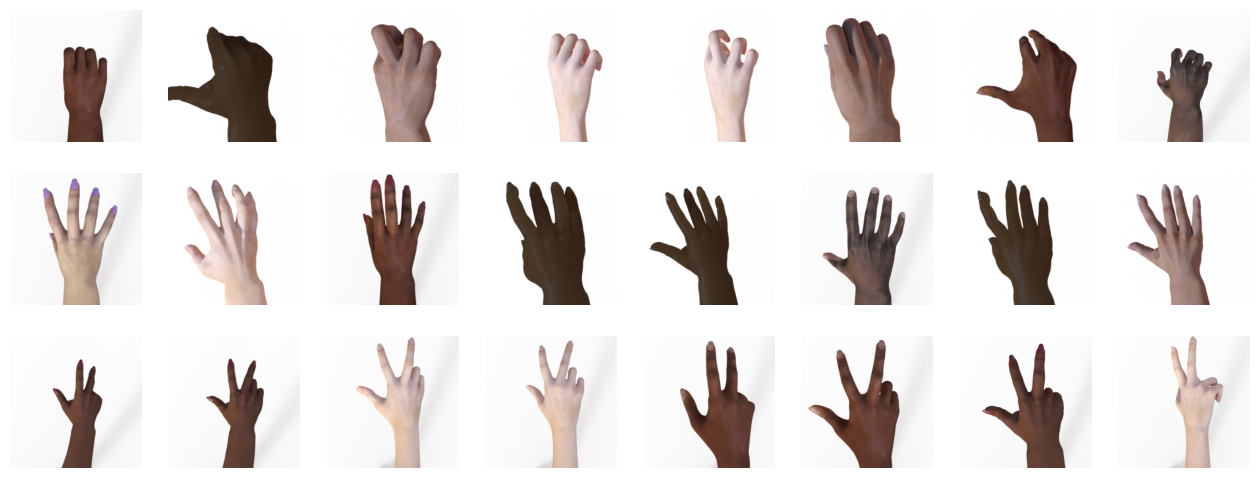

In [5]:
#@ display images
nrows = 3
ncols = 8

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)
rock_pics = [os.path.join(rock_dir, fname) for fname in random.choices(rock_files, k=8)]
paper_pics = [os.path.join(paper_dir, fname) for fname in random.choices(paper_files, k=8)]
scissors_pics = [os.path.join(scissors_dir, fname) for fname in random.choices(scissors_files, k=8)]

for i, img_path in enumerate(rock_pics+paper_pics+scissors_pics):
  sp = plt.subplot(nrows, ncols, i + 1) # set up subplot; subplot indices start at 1
  sp.axis('Off') # don't show axes or gridlines
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
import sys
sys.exit("Execution stopped. Please run cells selectively.")

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Training

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

history = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=20,
    validation_data=validation_generator,
    verbose=2
)

In [ ]:
plot_loss_acc(history)

# Prediction

In [ ]:
# uploaded = files.upload()

# for fn in uploaded.keys():

#   # predicting images
#   path = fn
#   img = load_img(path, target_size=(150, 150))
#   x = img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(fn)
#   print(classes)